In [1]:
# imports
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
# preparation

# init environments
envs = {
    # "one-agent", "two-agents", "two-agents-mixed", "two-agents-percentage", "three-agents"
    "one-agent": {"agent_amount": 1},
    "two-agents": {"agent_amount": 2},
    "two-agents-sm": {"agent_amount": 2},
    "two-agents-sm-mixed" : {"agent_amount": 2, "mixed": True},
    "two-agents-mixed": {"agent_amount": 2, "mixed": True},
    "two-agents-percentage": {
        "agent_amount": 2, 
        "percentage":True
    },
    "two-agents-sm-percentage": {
        "agent_amount": 2, 
        "percentage":True
    },
    "three-agents": {"agent_amount": 3}
}

# init data logging 
log_data = {}

In [7]:
# helper functions

def create_dataframe():
    # read files
    df_settings_dict = {}
    for setting in envs.keys():
        try:
            df_settings_dict[setting] = pd.read_csv('storage/'+setting+'/log.csv')
            # add setting to the df columns
            df_settings_dict[setting].columns = [setting + "_" + str(col) for col in df_settings_dict[setting].columns]
        except(FileNotFoundError):
            continue
    # join all dataframes (one per setting)
    df = pd.concat([df for df in df_settings_dict.values()], axis=1)
    return df

def extract_cols(df, key, agent_specific=False):
    result_cols = []
    
    for col in df.columns:
        if "frames" in col:
            # since frames don't differ between settings, but i.e. three agents need more frames pick the column that has the most values
            # (for example check if the value of the last index is not NaN)
            last_value = df[col].iloc[-1]
            if not np.isnan(last_value) and "frames" not in '\t'.join(result_cols):
                print(col)
                result_cols.append(col)

        if not agent_specific:
            if key in col:
                result_cols.append(col)
        else:
            if key+"_agent_0" in col:
                # always safe agent 0 values
                result_cols.append(col)
            elif "mixed" in col and key in col:
                # always add mixed values for each agent since they differ from each other
                result_cols.append(col)
               
    # print(result_cols)
    return result_cols

def get_frames_col_name(df_cols):
    for col in df_cols:
        if "frames" in col:
            return col

def convert_to_longform(df, key):
    frames_col = get_frames_col_name(df.columns)
    lf_df = df.melt(id_vars=[frames_col], var_name="setting", value_name=key)
    lf_df.rename(columns={frames_col:'frames'}, inplace=True)
    return lf_df

In [8]:
df = create_dataframe()

key_mean_rewards = "mean_reward"
key_mean_reset_fields = "mean_num_reset_fields"
key_mean_grid_coloration = "mean_grid_coloration_percentage"

# create one df only containing mean rewards per agent and frames 
df_mean_rewards = df[extract_cols(df, key_mean_rewards, agent_specific=True)].copy()
df_mean_reset_fields = df[extract_cols(df, key_mean_reset_fields)].copy()
df_mean_grid_coloration = df[extract_cols(df, key_mean_grid_coloration)].copy()

# reshape dataframes into longform
lf_df_mean_rewards = convert_to_longform(df_mean_rewards, key_mean_rewards)
lf_df_mean_reset_fields = convert_to_longform(df_mean_reset_fields, key_mean_reset_fields)
lf_df_mean_grid_coloration = convert_to_longform(df_mean_grid_coloration, key_mean_grid_coloration)


three-agents_frames
three-agents_frames
three-agents_frames


In [9]:

print(lf_df_mean_rewards)
print(lf_df_mean_reset_fields)
print(lf_df_mean_grid_coloration)

lf_df_mean_combined = lf_df_mean_reset_fields.join(lf_df_mean_grid_coloration[key_mean_grid_coloration])
print(lf_df_mean_combined)

      frames                           setting  mean_reward
0       2048     one-agent_mean_reward_agent_0     0.012500
1       4096     one-agent_mean_reward_agent_0     0.000000
2       6144     one-agent_mean_reward_agent_0     0.000000
3       8192     one-agent_mean_reward_agent_0     0.012500
4      10240     one-agent_mean_reward_agent_0     0.025000
...      ...                               ...          ...
1710  493568  three-agents_mean_reward_agent_0     0.013100
1711  495616  three-agents_mean_reward_agent_0     0.000000
1712  497664  three-agents_mean_reward_agent_0     0.008772
1713  499712  three-agents_mean_reward_agent_0     0.008811
1714  501760  three-agents_mean_reward_agent_0     0.013100

[1715 rows x 3 columns]
      frames                             setting  mean_num_reset_fields
0       2048     one-agent_mean_num_reset_fields               3.450000
1       4096     one-agent_mean_num_reset_fields               3.475000
2       6144     one-agent_mean_num_res

<AxesSubplot:xlabel='frames', ylabel='mean_grid_coloration_percentage'>

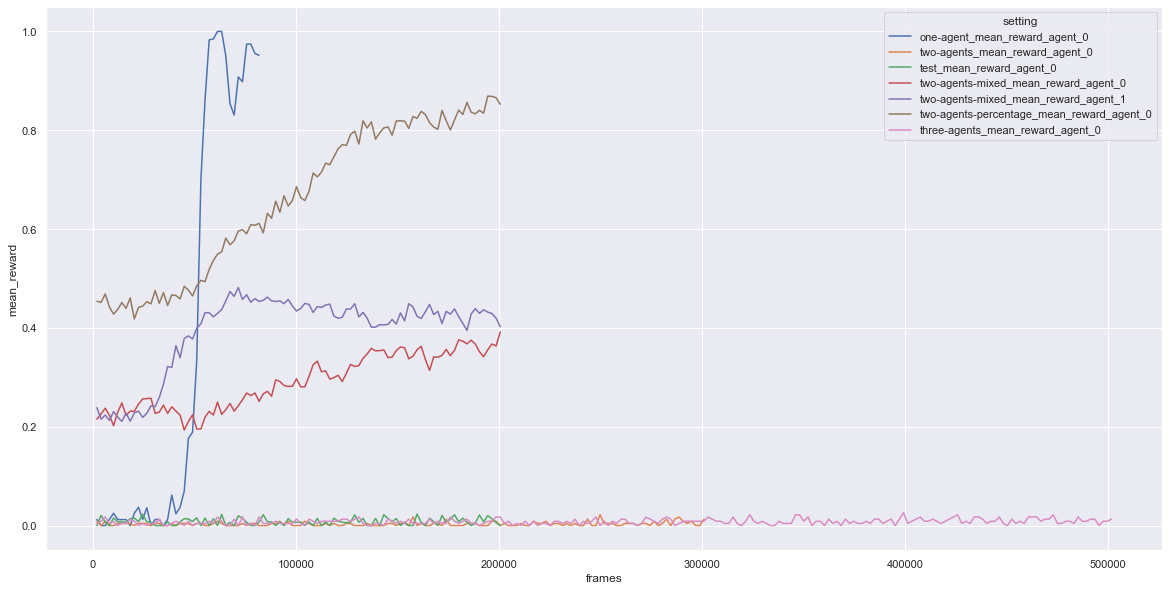

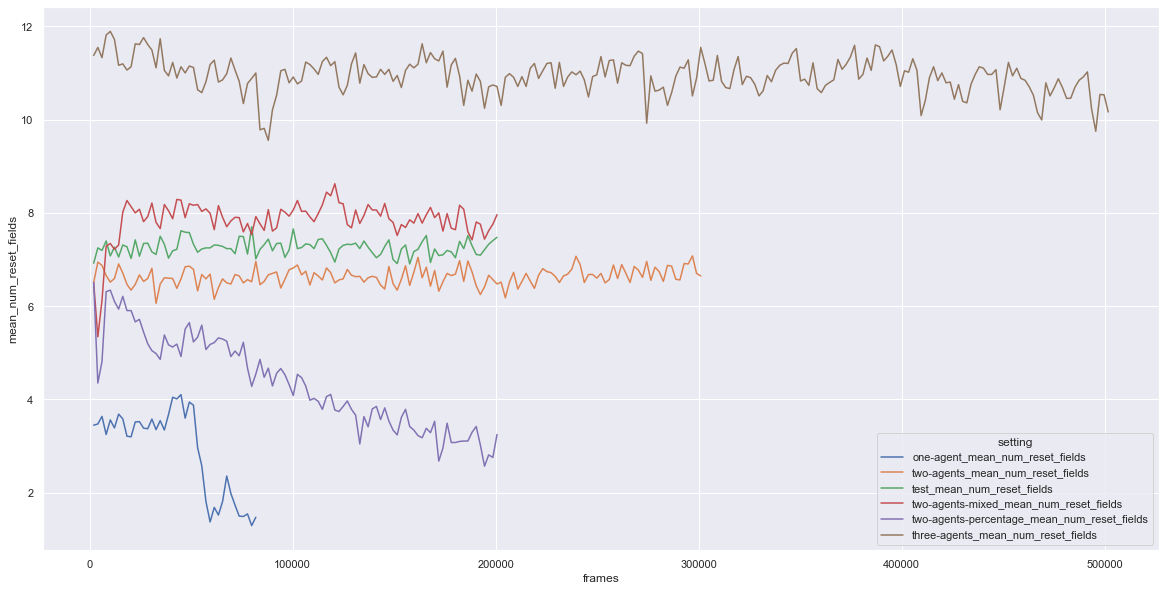

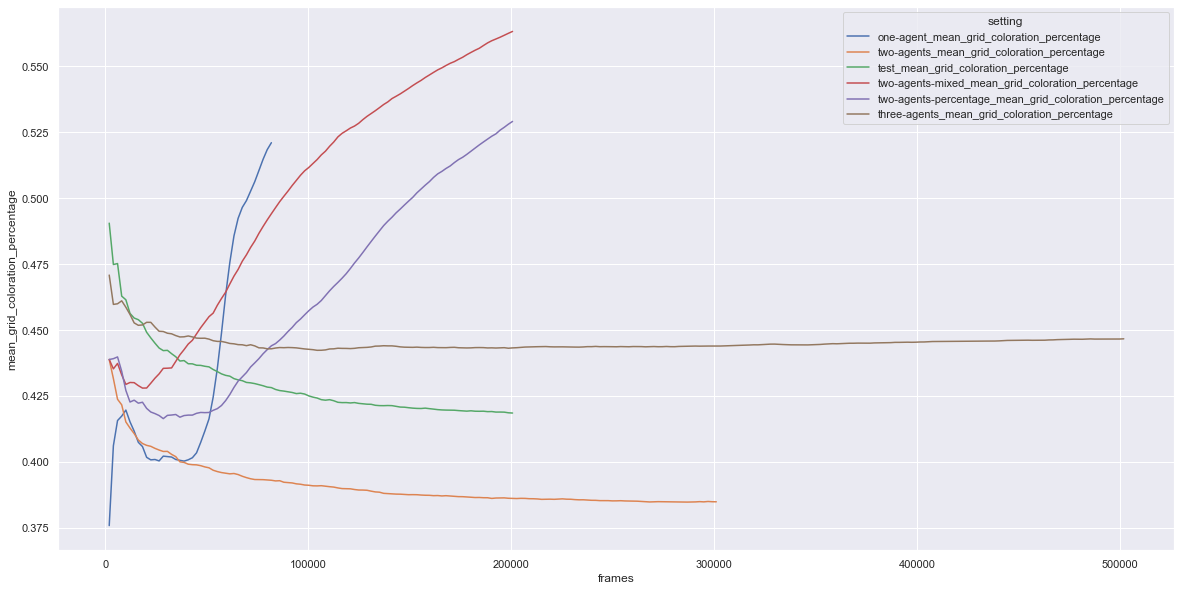

In [10]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(20,10))
# Plot the responses for different events and regions
sns.lineplot(x="frames", y=key_mean_rewards,
             hue="setting",
             data=lf_df_mean_rewards)

plt.figure(figsize=(20,10))
# Plot the responses for different events and regions
sns.lineplot(x="frames", y=key_mean_reset_fields,
             hue="setting",
             data=lf_df_mean_reset_fields)

plt.figure(figsize=(20,10))
# Plot the responses for different events and regions
sns.lineplot(x="frames", y=key_mean_grid_coloration,
             hue="setting",
             data=lf_df_mean_grid_coloration)